# Forwards Amortised Optimisation

This notebook shows how to compare the performance of different forward amortisation model structures.

Note: We are not trying to get a good result here, just showing how to compare different model! The final optimisers will not converge because they have not been trained for long enough.

Note: This is running on the development version of dLux, so it will not be able to be replicated until the changes are merged

In [1]:
# Packages
import jax
import zodiax as zdx
import equinox as eqx
import dLux as dl
import optax

# Modules
from jax import numpy as np, random as jr, tree_util as jtu
from dLux import layers as dll, utils as dlu
import matplotlib.pyplot as plt
from matplotlib import colormaps
from tqdm.notebook import tqdm

from lib import OptNet, Trainer, sample_normal
from plotting import plot_grid_2d, add_cbar

%matplotlib inline
plt.rcParams['image.cmap'] = 'inferno'
plt.rcParams["font.family"] = "serif"
plt.rcParams["image.origin"] = 'lower'
plt.rcParams['figure.dpi'] = 96
%matplotlib inline

## Make Optics

In [2]:
# Source parameters
wavelengths = 1e-6 * np.linspace(1., 1.2, 5)
source = dl.PointSource(wavelengths, flux=1e4)

# Wavefront parameters
wf_npix = 256
aper_diam = 2.4

# Generate an aperture manually
coords = dlu.pixel_coords(5*wf_npix, 2.4)
spider_angles = 45 + np.linspace(0, 360, 4, endpoint=False)
outer = dlu.circle(coords, aper_diam/2)
inner = dlu.circle(coords, .3, True)
spiders = dlu.spider(coords, .05, spider_angles)
aperture = dlu.combine([outer, inner, spiders], 5)

# Generate coordinates
coords = dlu.pixel_coords(wf_npix, 2.4)
zernikes = np.arange(2, 4)
basis = np.array([1e-9 * dlu.zernike(i, coords, aper_diam) for i in zernikes])
coeffs = 4e1 * jr.normal(jr.PRNGKey(0), (len(zernikes),))

# PSF parameters
psf_wf_npix = 64
sampling = 3 # ie 1.5x Nyquist
fringe_size = dlu.fringe_size(wavelengths, aper_diam).min()
psf_pix_scale = 1.22 * dlu.rad2arcsec(fringe_size) / sampling

# Construct optics & Telescope
psf_oversample = 3
layers = [('aperture', dll.BasisOptic(
    aperture, basis, coeffs, normalise=True
))]
optics = dl.AngularOptics(
    wf_npix, aper_diam, layers, psf_wf_npix, psf_pix_scale / psf_oversample
    )
fmodel = dl.Telescope(optics, source)

## Examine

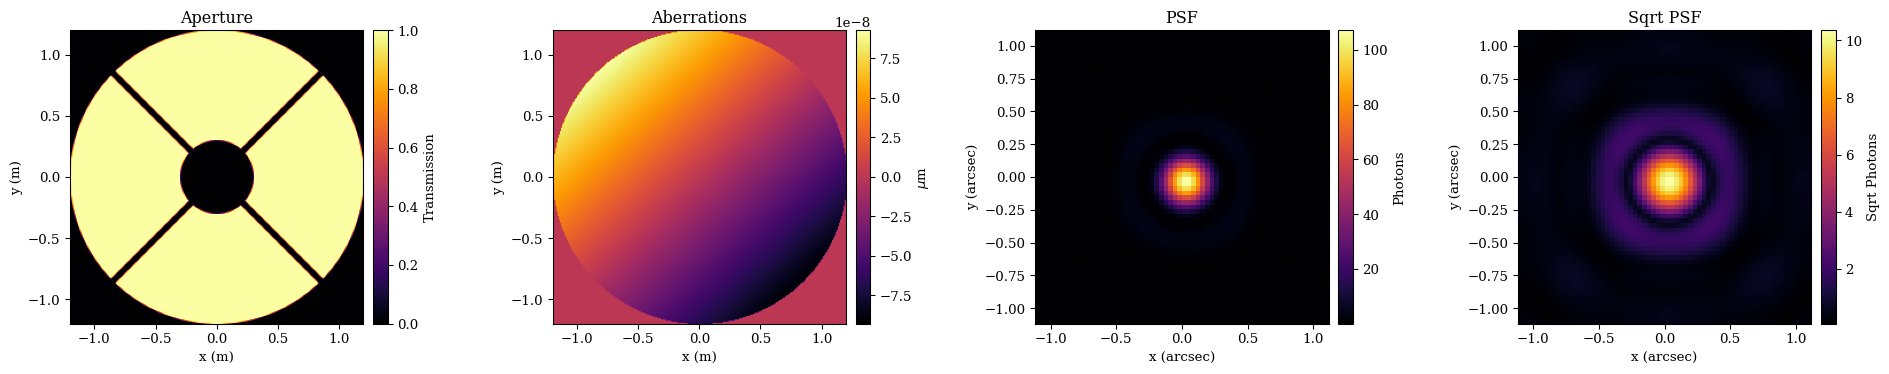

In [3]:
fig, axes = plot_grid_2d(1, 4)

# Aperture plots
r = aper_diam/2
extent = (-r, r, -r, r)

axes[0].set(xlabel='x (m)', ylabel='y (m)', title='Aperture')
im = axes[0].imshow(optics.transmission, extent=extent)
add_cbar(fig, axes[0], im, label='Transmission')

axes[1].set(xlabel='x (m)', ylabel='y (m)', title='Aberrations')
im = axes[1].imshow(optics.eval_basis(), extent=extent)
add_cbar(fig, axes[1], im, label='$\mu$m')

# PSF plots
psf = fmodel.model()
r = psf_pix_scale * psf_wf_npix / 2
extent = (-r, r, -r, r)

axes[2].set(xlabel='x (arcsec)', ylabel='y (arcsec)', title='PSF')
im = axes[2].imshow(psf, extent=extent)
add_cbar(fig, axes[2], im, label='Photons')

axes[3].set(xlabel='x (arcsec)', ylabel='y (arcsec)', title='Sqrt PSF')
im = axes[3].imshow(psf**0.5, extent=extent)
add_cbar(fig, axes[3], im, label='Sqrt Photons')
fig.tight_layout()

# Set up samples and train!

In [4]:
# Create model & Optimise
depths = [0, 1, 2]
epochs, batch_size = 200, 100
truth = np.zeros(2)
optim = optax.adam(1e-1)

trainers = []
for depth in depths:
    init_model = OptNet(fmodel, 'coefficients', depth=depth, use_loss=True)
    trainer = Trainer(init_model, optim) # No key, initialised to zero

    samples = sample_normal(epochs, batch_size, zernikes.shape, sigma=1e2, key=0)
    trainers.append(trainer.train_single(samples, truth=truth, kth=epochs//10))

Supervised training


Loss:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 	 Loss 8.6779
Epoch: 20 	 Loss -0.90448
Epoch: 40 	 Loss -3.2387
Epoch: 60 	 Loss -11.348
Epoch: 80 	 Loss -15.606
Epoch: 100 	 Loss -18.776
Epoch: 120 	 Loss -26.499
Epoch: 140 	 Loss -21.017
Epoch: 160 	 Loss -24.003
Epoch: 180 	 Loss -23.495
Epoch: 200 	Loss -21.31
Supervised training


Loss:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 	 Loss 0.63768
Epoch: 20 	 Loss -0.061255
Epoch: 40 	 Loss 0.086058
Epoch: 60 	 Loss -0.070748
Epoch: 80 	 Loss 0.092906
Epoch: 100 	 Loss -0.011919
Epoch: 120 	 Loss -0.085708
Epoch: 140 	 Loss 0.092766
Epoch: 160 	 Loss -0.013306
Epoch: 180 	 Loss 0.0080456
Epoch: 200 	Loss 0.032564
Supervised training


Loss:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch: 0 	 Loss -0.0056276
Epoch: 20 	 Loss -6.0721
Epoch: 40 	 Loss -15.61
Epoch: 60 	 Loss -25.956
Epoch: 80 	 Loss -20.354
Epoch: 100 	 Loss -23.086
Epoch: 120 	 Loss -26.562
Epoch: 140 	 Loss -20.714
Epoch: 160 	 Loss -23.696
Epoch: 180 	 Loss -21.227
Epoch: 200 	Loss -28.211


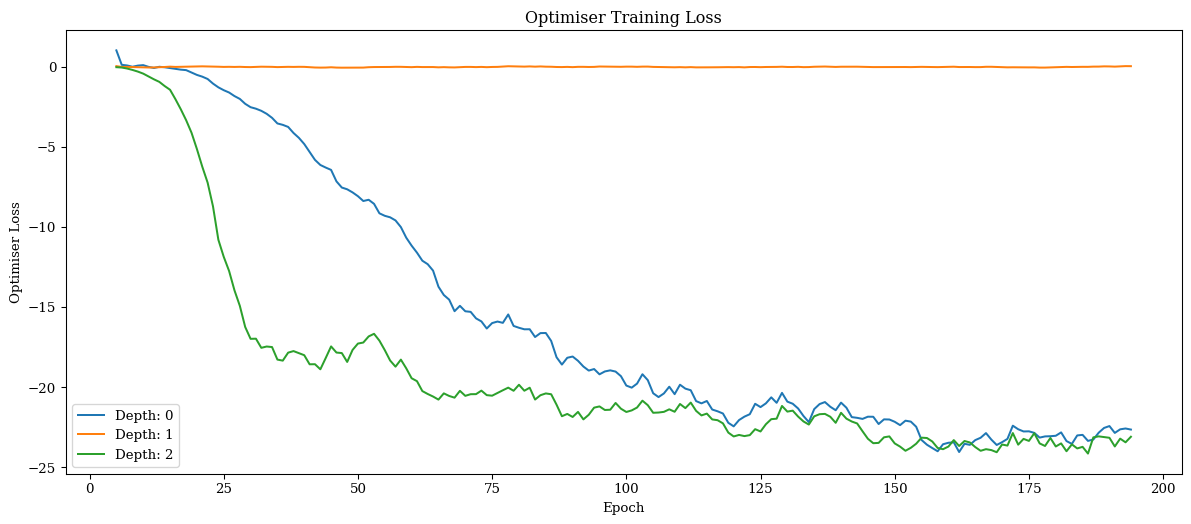

In [5]:
n = 10
take_mean = lambda arr, n: np.array([arr[i:i+n].mean() for i in range(len(arr) - n)])

plt.figure(figsize=(15, 6))
plt.title("Optimiser Training Loss")
for i, trainer in enumerate(trainers):
    smooth_losses = take_mean(trainer.losses, n)
    xs = np.arange(n//2, len(trainer.losses)-n//2)

    # plt.plot(trainer.losses, label=f'Depth: {depths[i]}')
    plt.plot(xs, smooth_losses, label=f'Depth: {depths[i]}')
    plt.xlabel('Epoch')
    plt.ylabel('Optimiser Loss')
plt.legend()
plt.show()

The depth = 2 model seems to be unable to learn anything, no clue why!

# Compare trained optimiser to SGD

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

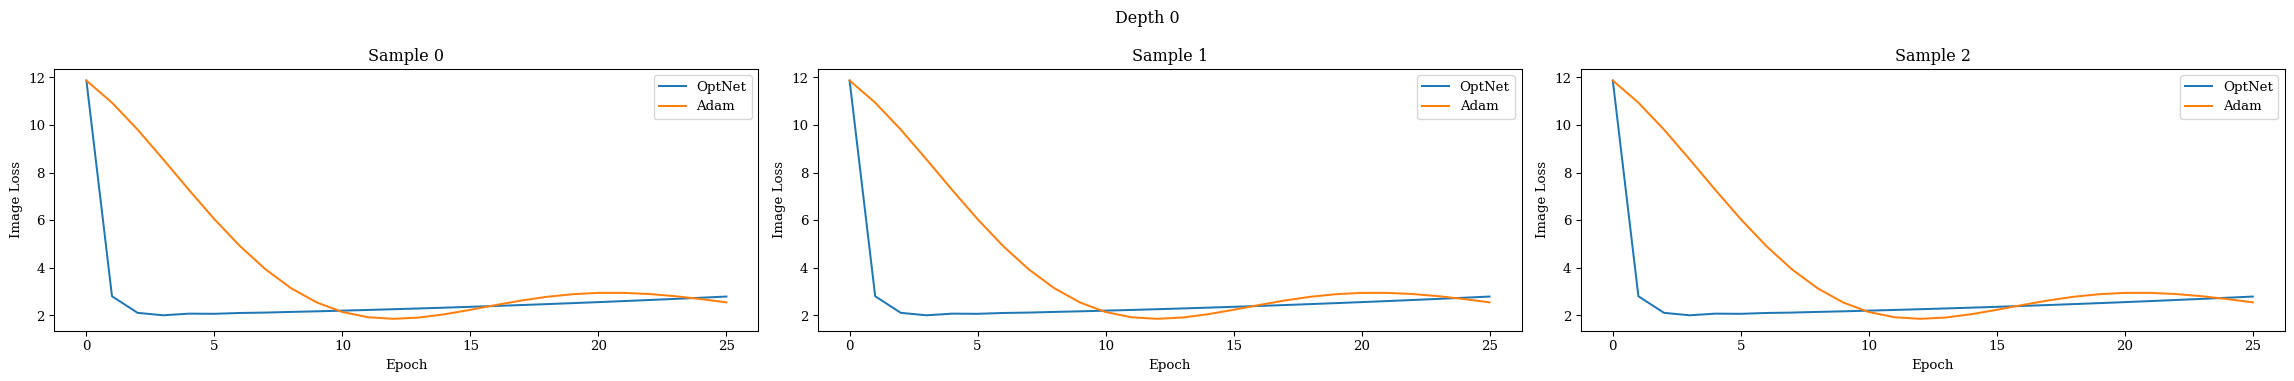

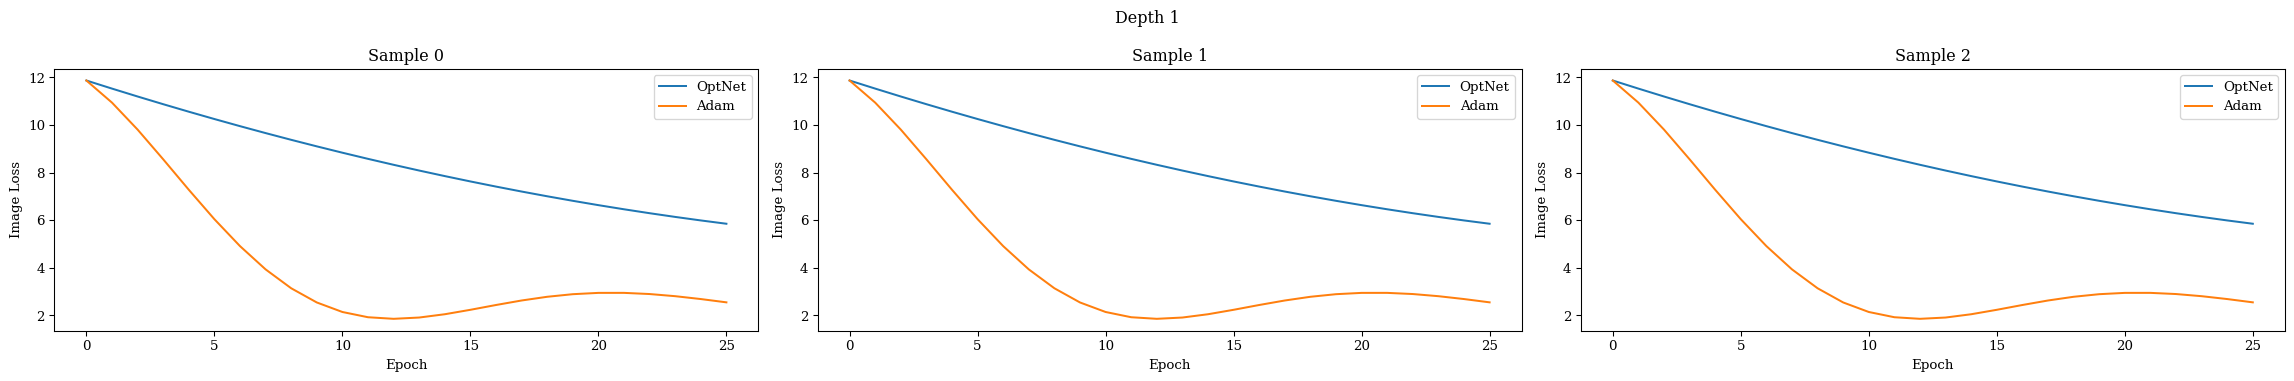

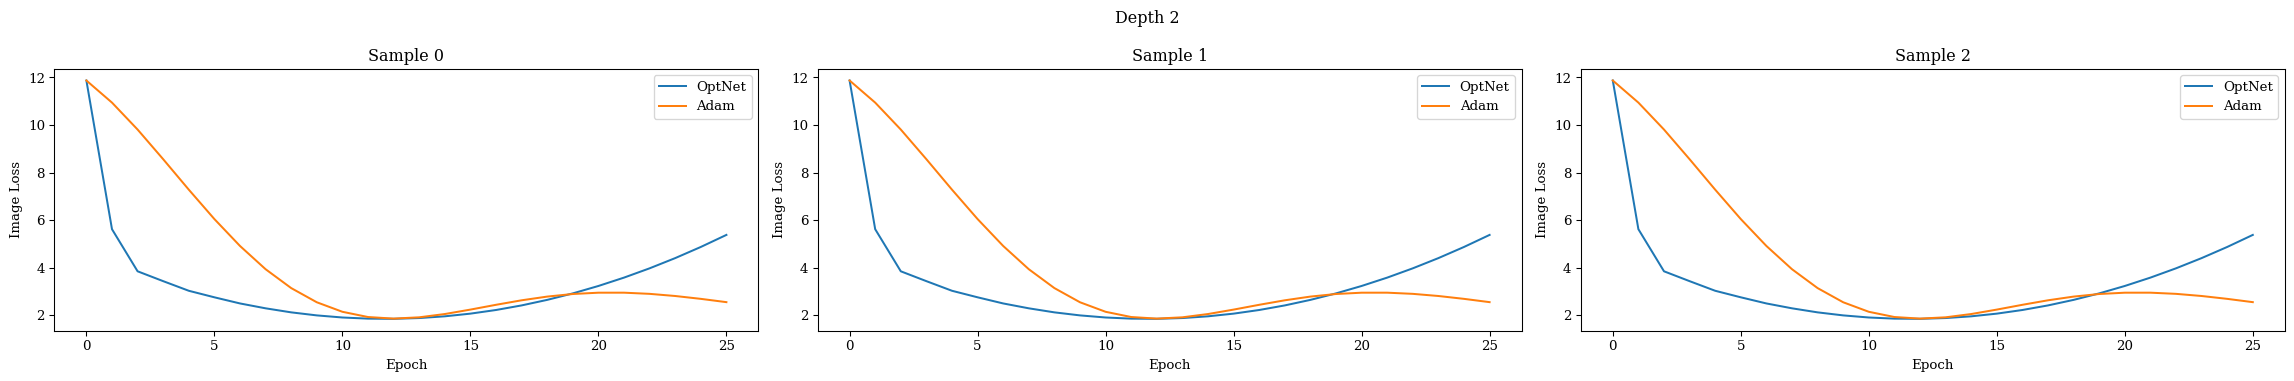

In [6]:
# Initial Conditions
key, sigma = 1, 1e2
n_samples = 3
vals = np.squeeze(sample_normal(n_samples, 1, zernikes.shape, sigma=sigma, key=key))

def update(model, values):
    return model.fmodel.set(model.params, values)

n_epochs = 25
for k, trainer in enumerate(trainers):

    # Get the optimiser model
    model = trainer.model
    psf = model.fmodel.model()
    optim = optax.adam(1e1)
    opt_state = optim.init(model.fmodel.get(model.params))
        
    for j in tqdm(range(n_samples)):
        data = jr.poisson(jr.PRNGKey(j), psf)

        
        initial_loss = model.image_loss(update(model, vals[j]), data)
        pred, naive = vals[j], vals[j]
        naive_losses, pred_losses = [initial_loss], [initial_loss]
        for i in tqdm(range(n_epochs), leave=False):

            # get predictions
            pred = model.predict(pred, data)
            grads = model.eval_grads(naive, data).get(model.params)
            updates, opt_state = optim.update(grads, opt_state)
            naive = zdx.apply_updates(naive, updates)

            # Get losses
            pred_losses.append(model.image_loss(update(model, pred), data))
            naive_losses.append(model.image_loss(update(model, naive), data))
        
    fig, axes = plot_grid_2d(1, (len(trainers)), fsx=8)
    fig.suptitle(f"Depth {depths[k]}")
    for i in range(len(axes)):
        axes[i].set(xlabel='Epoch', ylabel='Image Loss', title=f"Sample {i}")
        axes[i].plot(pred_losses, label='OptNet')
        axes[i].plot(naive_losses, label='Adam')
        axes[i].legend()
    fig.tight_layout()

# Examine the improvement from a single step

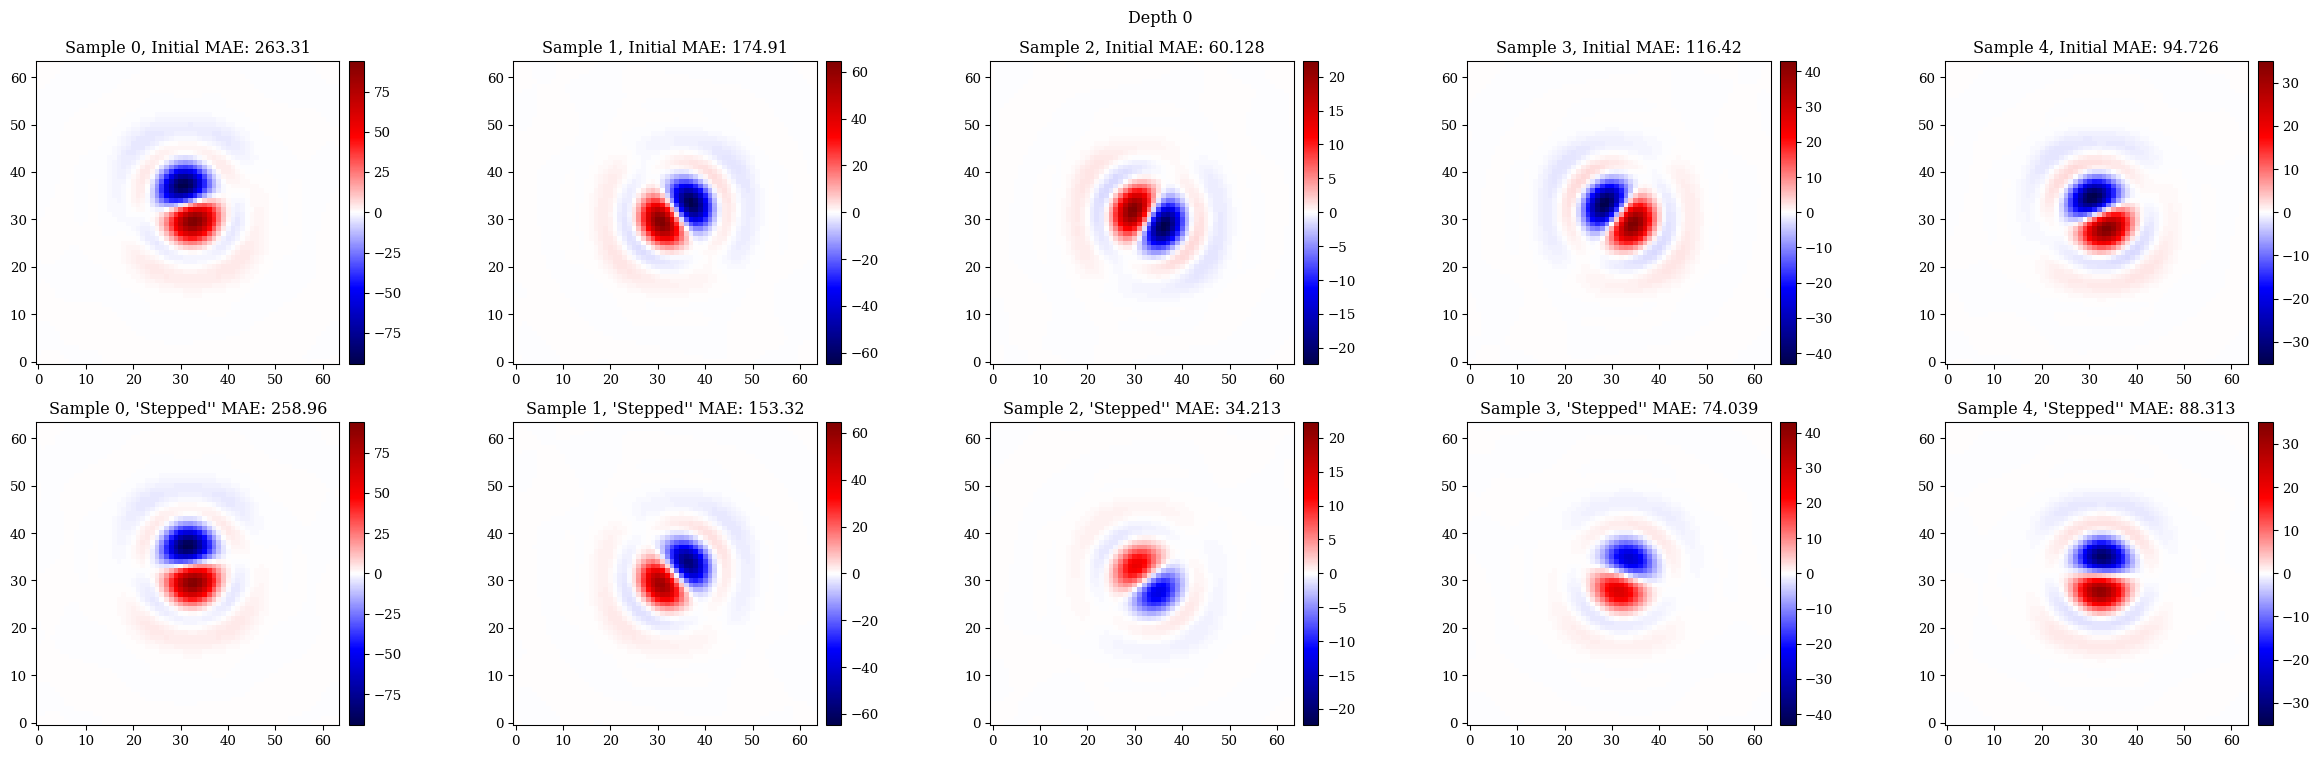

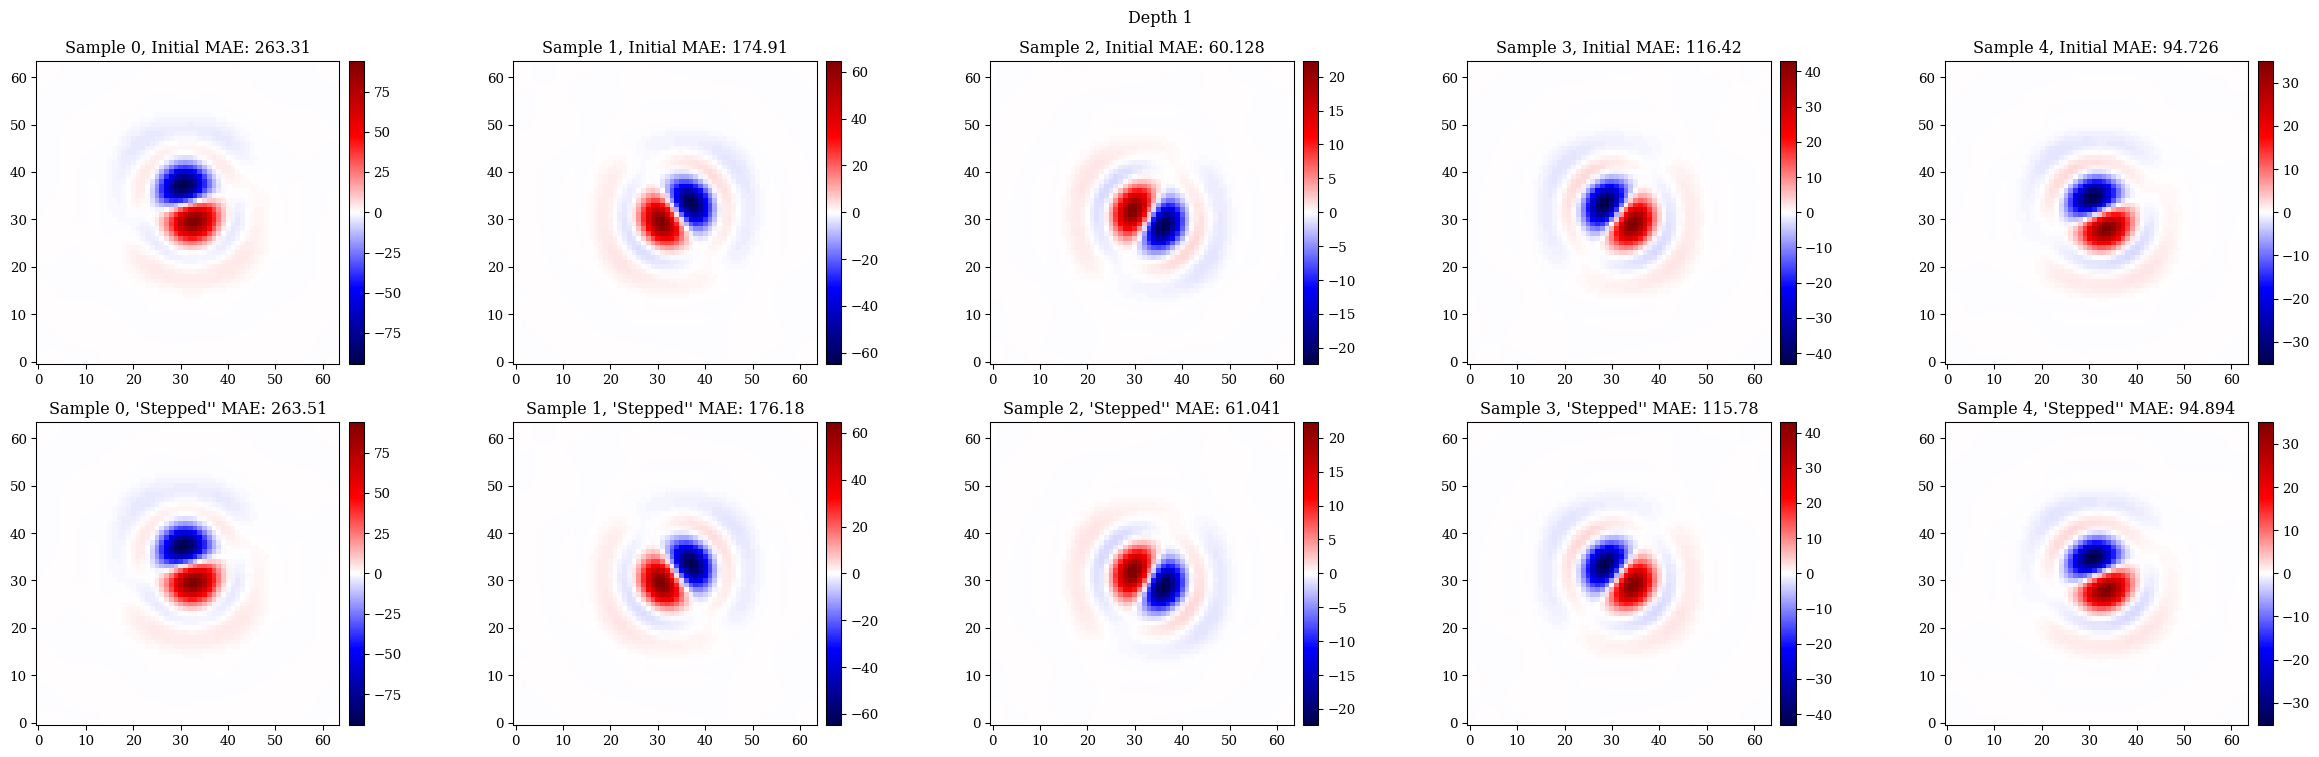

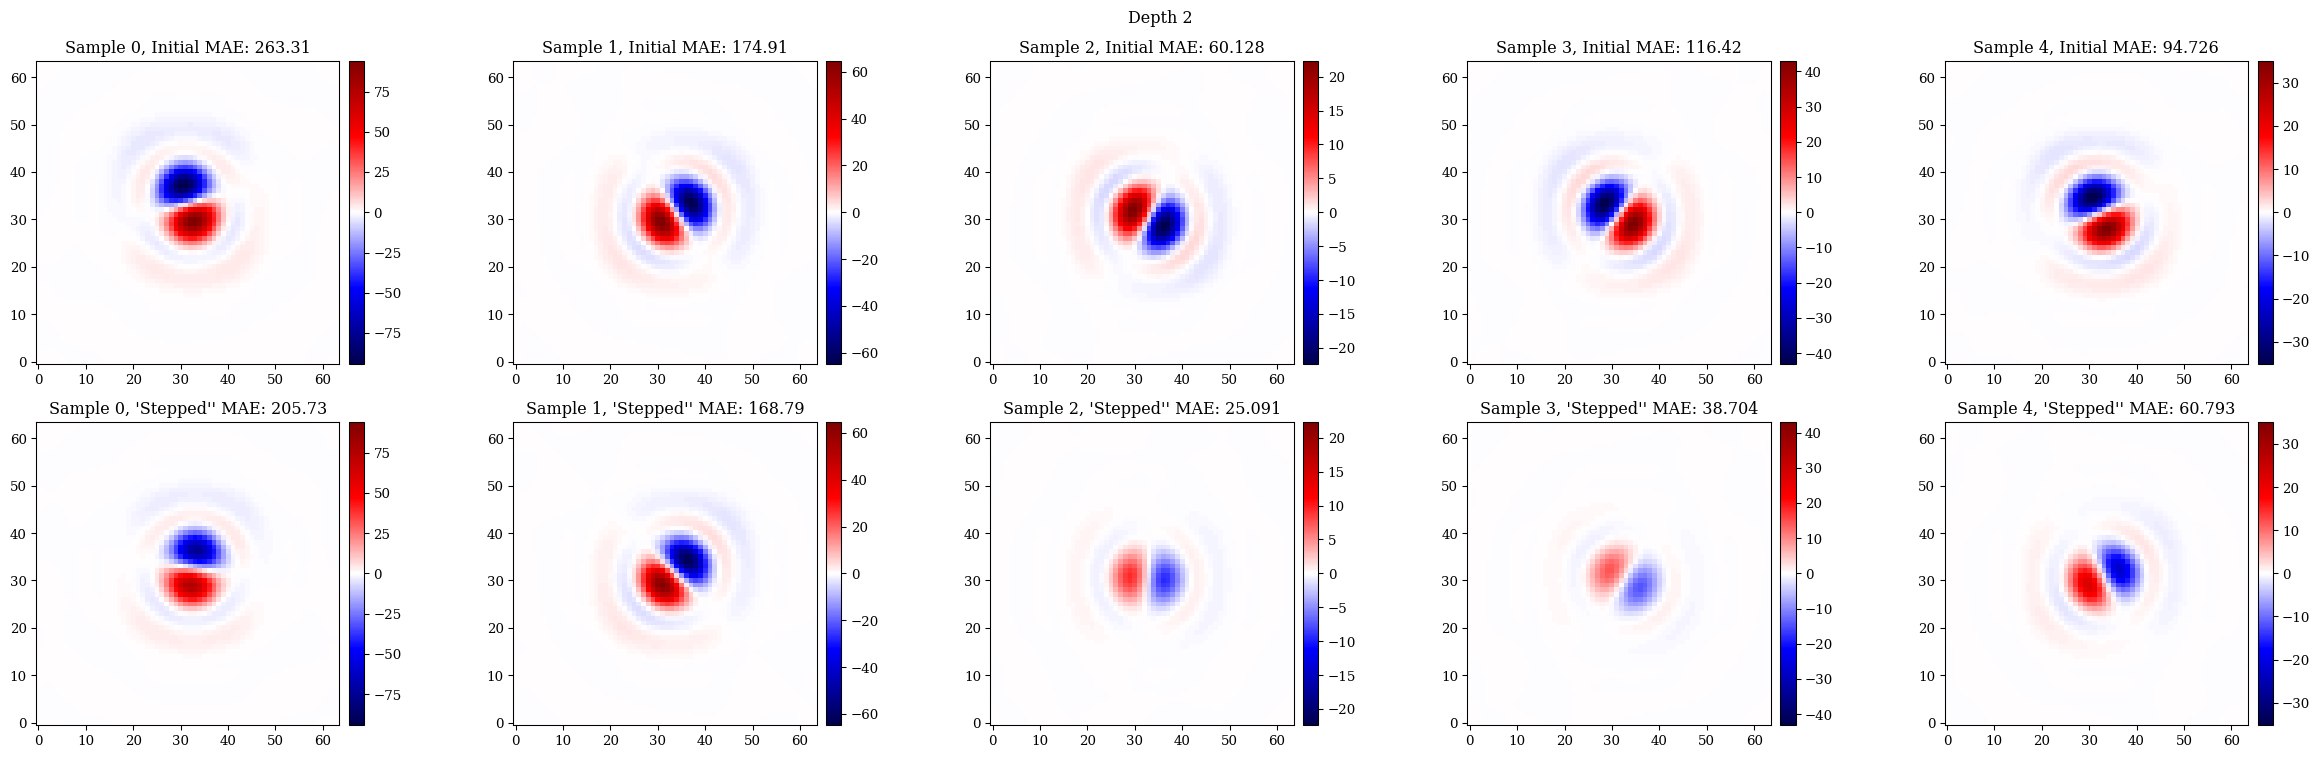

In [7]:
for i, trainer in enumerate(trainers):
    model = trainer.model
    psf = model.fmodel.model()

    # Get Initial Residuals
    rows, cols = 1, 5
    init_residuals = psf[None, ...] - model.model_values(samples[0, :rows*cols])
    new_values = jax.vmap(model.predict, (0, None))(samples[0, :rows*cols], psf)
    final_residuals = psf[None, ...] - model.model_values(new_values)

    # Get normalisation values so we have same colour scale for each sample
    vmin = init_residuals.min((-1, -2))
    vmax = init_residuals.max((-1, -2))
    v = np.abs(np.array([vmin, vmax])).max(0)

    # Get a sample of the training samples
    fig, axes = plot_grid_2d(2*rows, cols)
    fig.suptitle(f"Depth {depths[i]}")

    # Plot initial values
    for i in range(len(axes)//2):
        axes[i].set(xlabel='', ylabel='', title=f"Sample {i}, Initial MAE: {1e2 * np.mean(np.abs(init_residuals[i])):.5}")
        im = axes[i].imshow(init_residuals[i], vmin=-v[i], vmax=v[i], cmap='seismic')
        fig = add_cbar(fig, axes[i], im)

    # Plot final values
    for i in range(len(axes)//2):
        j = i + rows*cols
        axes[j].set(xlabel='', ylabel='', title=f"Sample {i}, 'Stepped'' MAE: {1e2 * np.mean(np.abs(final_residuals[i])):.5}")
        im = axes[j].imshow(final_residuals[i], vmin=-v[i], vmax=v[i], cmap='seismic')
        fig = add_cbar(fig, axes[j], im)
    fig.tight_layout()

# Examine optimiser values

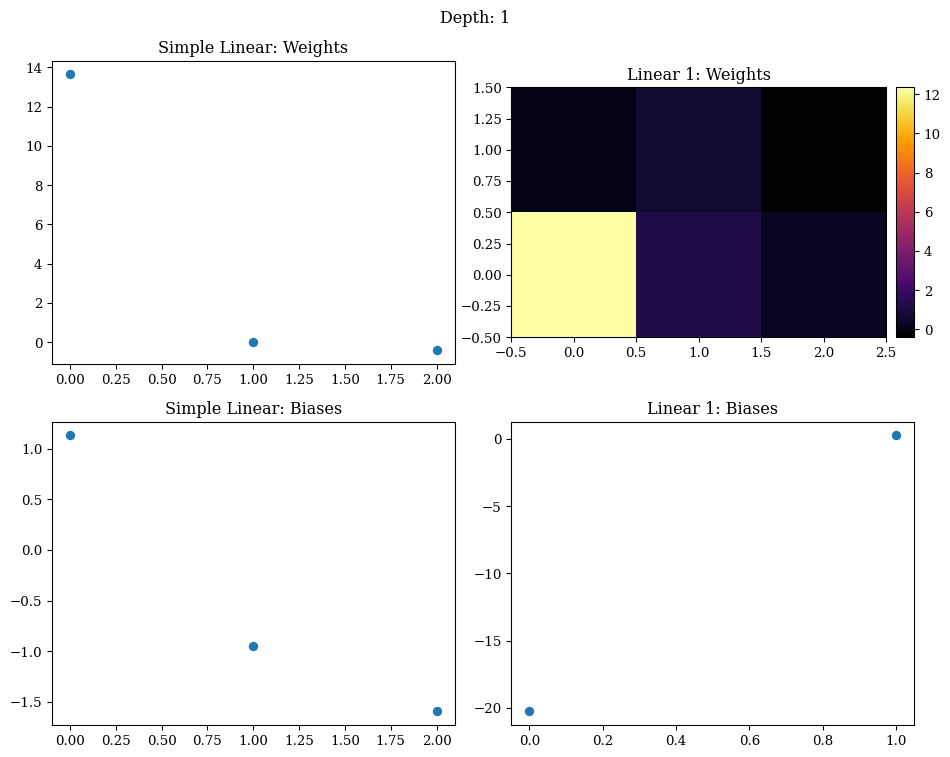

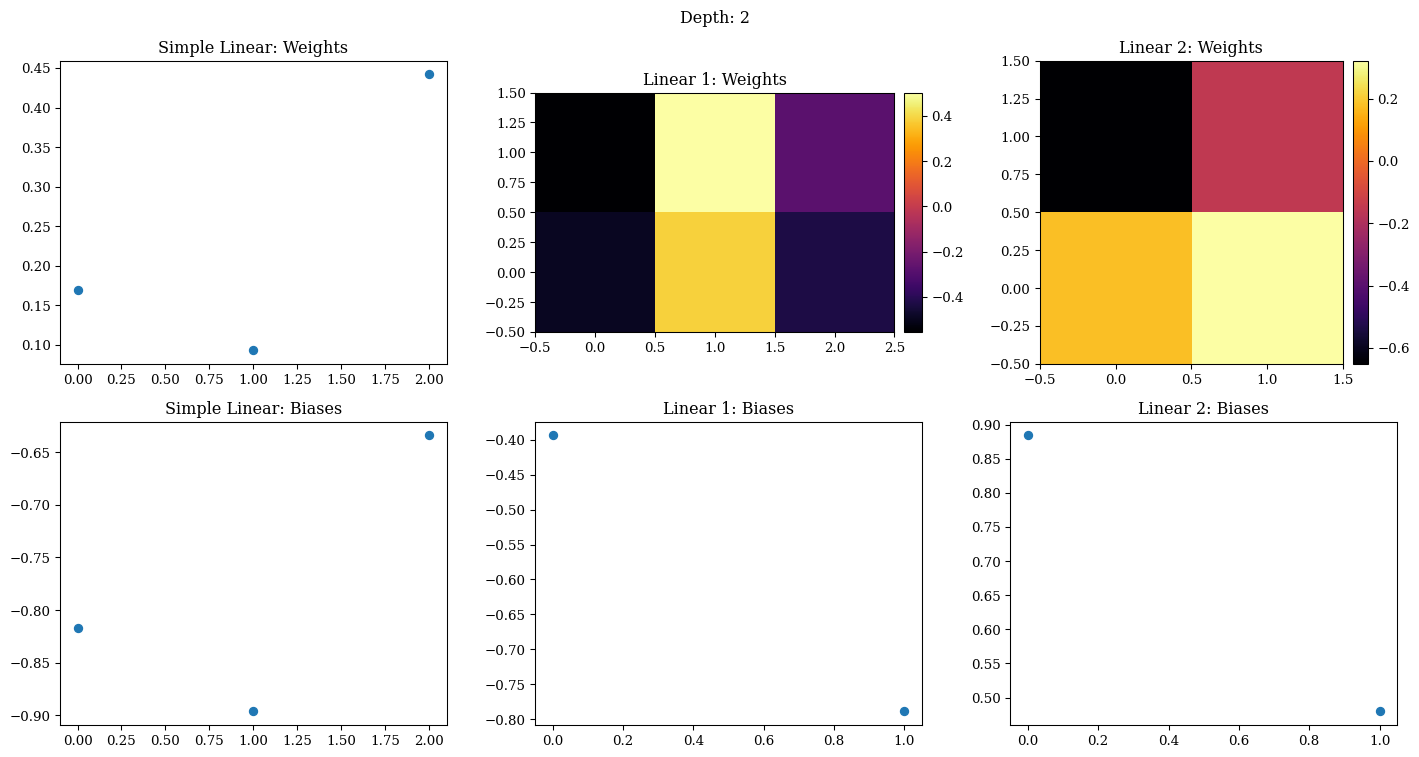

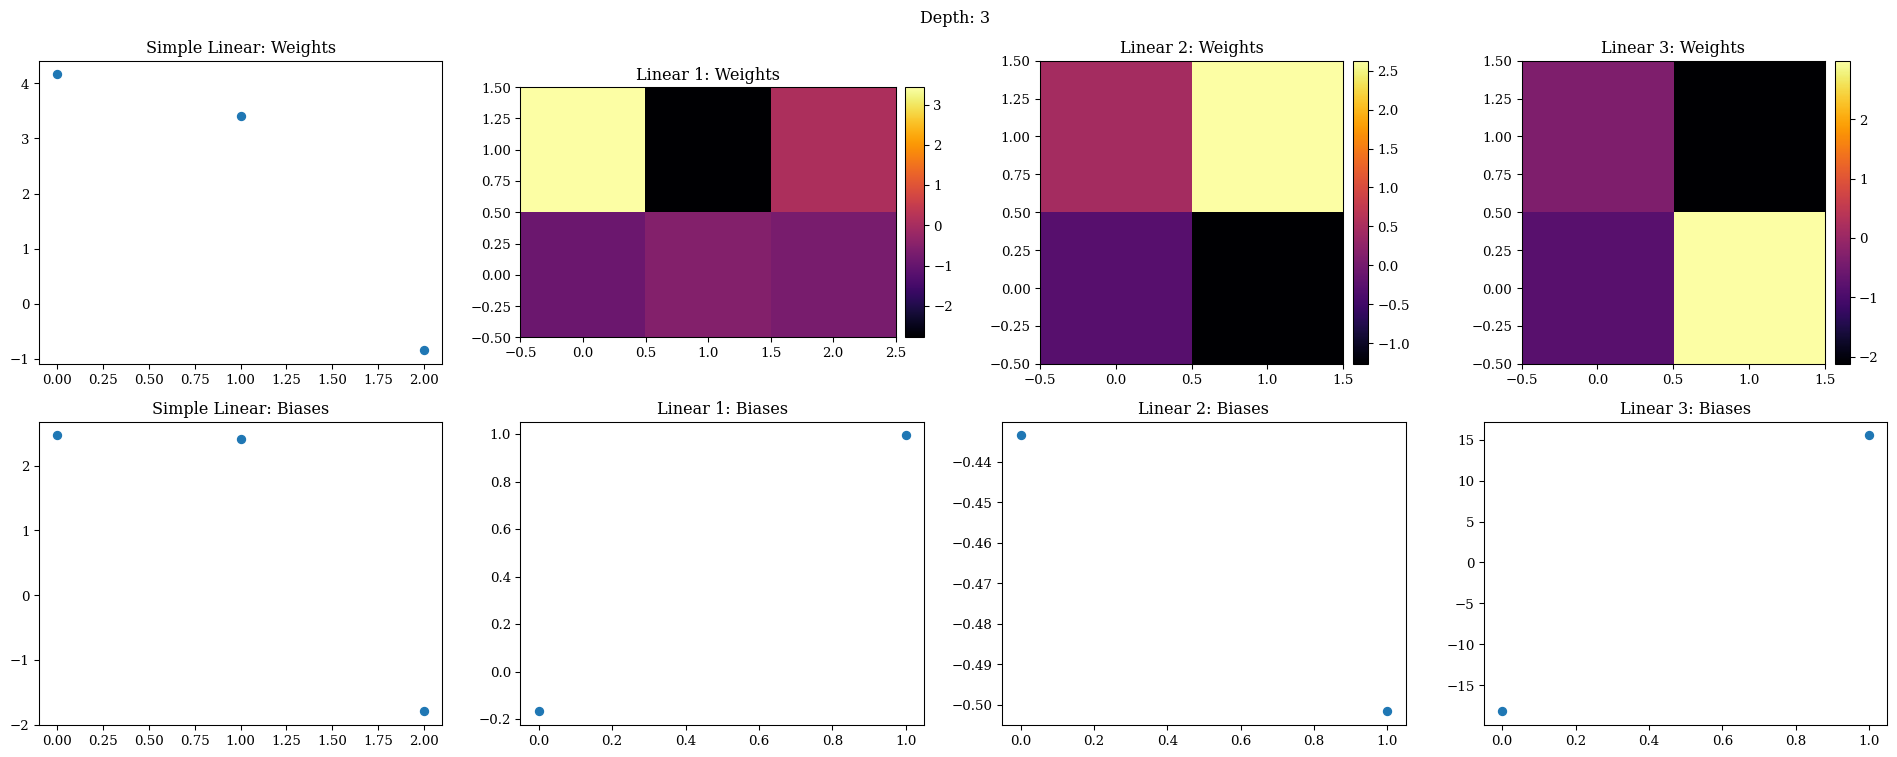

In [8]:
def visualise_optimiser(optimiser):

    layers = optimiser.layers
    depth = len(layers)
    
    fig, axes = plot_grid_2d(2, depth, fsx=5, fsy=4)
    fig.suptitle(f"Depth: {depth-1}")

    # First layer is always SimpleLinear
    xs = np.arange(len(layers[0].weight))
    axes[0].set(title="Simple Linear: Weights")
    axes[0].scatter(xs, layers[0].weight)

    axes[depth].set(title="Simple Linear: Biases")
    axes[depth].scatter(xs, layers[0].bias)

    # All other layers are Linear
    for i in range(1, depth):
        axes[i].set(title=f"Linear {i}: Weights")
        im = axes[i].imshow(layers[i].weight)
        fig = add_cbar(fig, axes[i], im)

    xs = np.arange(len(layers[1].weight))
    for j in range(1, depth):
        i = depth + j
        axes[i].set(title=f"Linear {j}: Biases")
        axes[i].scatter(xs, layers[j].bias)
    fig.tight_layout()

[visualise_optimiser(trainer.model.optimiser) for trainer in trainers];